# Decoding specified HybrISS tile(s)
This notebook provides an exampe how to decode a HybriISS tile from the human brain dataset used in the PoSTcode paper.

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
from postcode.decoding_functions import *
from postcode.spot_detection_functions import *
from postcode.reading_data_functions import *

In [3]:
%load_ext autoreload
%autoreload 2

* Specify directory location ``data_path`` with channel_info.csv and taglist.csv

In [4]:
dataset_name = 'N1234F_OB10037_x20'
data_path = '/nfs/research1/gerstung/mg617/ISS_data/' + dataset_name + '/'

* Read channel_info.csv and taglist.csv files

In [5]:
barcodes_01, K, R, C, gene_names, channels_info = read_taglist_and_channel_info(data_path)

## Spot detection

* Specify input parameters for spot detection via trackpy in dictionary ``spots_params``, which has to contain value for key ``'trackpy_spot_diam'`` indicating spot diameter in pixels. Here, a single tile with coordinates 'X12_Y1' is loaded from directory ``data_path``, which contains tile_names.csv and sub-directory ``tifs_path = data_path + 'selected-tiles/'`` with registered tif files. 

In [6]:
spots_params = {'trackpy_spot_diam':5} #parameters for spot detection: spot diameter must to be specified
spots_params['trackpy_prc'] = 75 #may use after_correction_decrease_prc_by>0 to incerease number of selected spots after registration correction
spots_params['trackpy_search_range'] = 6 #for initial tracking to do registration correction
tifs_path = data_path + 'selected-tiles/'
tile_names = read_csv(data_path + 'tile_names.csv')
x_min, x_max, y_min, y_max = find_xy_range_of_tile_names(tile_names['selected_tile_names'])
tiles_info = {'tile_size':2000, 'y_max_size':2000, 'x_max_size':2000, 'filename_prefix':'cycles_combined_opt_flow_registered_', 'y_max':y_max, 'x_max':x_max}
tiles_to_load = {'y_start':15, 'y_end':15, 'x_start':6, 'x_end':6} #tile(s) to load 
spots_out = load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params, 
                                        ind_cy_move_forward_by=1, #becuase c01 is the reference cylce without coding channels
                                        anchor_available=False, #fake anchors should be generated for spot detection
                                        correct_reg_via_trackpy=True, #trackpy corrects registration by linear shifting using fake anchors but keeps spots from first frame only
                                        after_correction_decrease_sep_by=3, # decrease separation in trackpy.locate after registration correction
                                        return_anchors=True)                                                              

100%|██████████| 1/1 [00:41<00:00, 41.50s/it]


In [7]:
print('In total {} spots were detected.'.format(spots_out['spots'].shape[0]))

In total 7247 spots were detected.


## Spot decoding

* Estimate model parameters and compute class probabilities

In [8]:
out = decoding_function(spots_out['spots'], barcodes_01, print_training_progress=True)

/homes/mg617/virtualEnvs/pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
100%|██████████| 4097/4097 [00:05<00:00, 749.35it/s]


* Create a data frame from the decoding output

In [9]:
df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
df_class_codes = np.concatenate((channels_info['barcodes_AGCT'],['inf','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_out['spots_loc']], axis=1) 

## Visualizing decoding results

* Plot loss, estimated activation parameters and covariance: loss should decrease, $\hat\alpha+\hat\beta$ shoud be separated from $\hat\alpha$, covariance matrix should have a checkerboard pattern

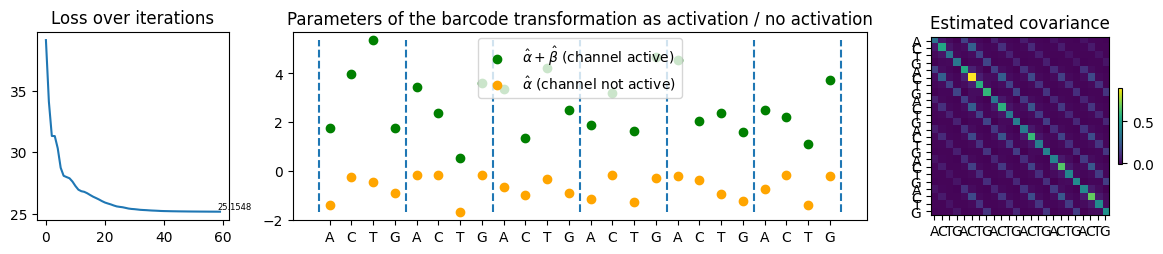

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 3, 1]}, figsize=(14, 2.5), dpi=100, facecolor='w', edgecolor='k')
channel_base = np.array(channels_info['channel_base'])[np.where(np.array(channels_info['coding_chs']) == True)[0]]
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
ax1.plot(np.arange(0,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'])))
ax1.annotate(np.round(1/out['class_probs'].shape[0]*out['params']['losses'][-1],4),(-2+len(out['params']['losses']),0.2+1/out['class_probs'].shape[0]*out['params']['losses'][-1]),size=6)
ax1.set_title('Loss over iterations')
ax2.scatter(np.arange(1,1+R*C),activation,c='green',label=r'$\hat{\alpha}+\hat{\beta}$ (channel active)') 
ax2.scatter(np.arange(1,1+R*C),no_activation,c='orange',label=r'$\hat{\alpha}$ (channel not active)') 
ax2.legend(loc=9)
ax2.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
ax2.set_xticks(np.arange(1,1+R*C))
ax2.set_xticklabels(np.tile(channel_base,R))
ax2.set_title('Parameters of the barcode transformation as activation / no activation')
covim = ax3.imshow(out['params']['sigma_star'])
ax3.set_xticks(np.arange(0,R*C))
ax3.set_xticklabels(np.tile(channel_base,R))
ax3.set_yticks(np.arange(0,R*C))
ax3.set_yticklabels(np.tile(channel_base,R))
ax3.set_title('Estimated covariance')
plt.colorbar(covim, ax=ax3, fraction=0.02)
plt.show()

* Plot histogram of barcode assignments

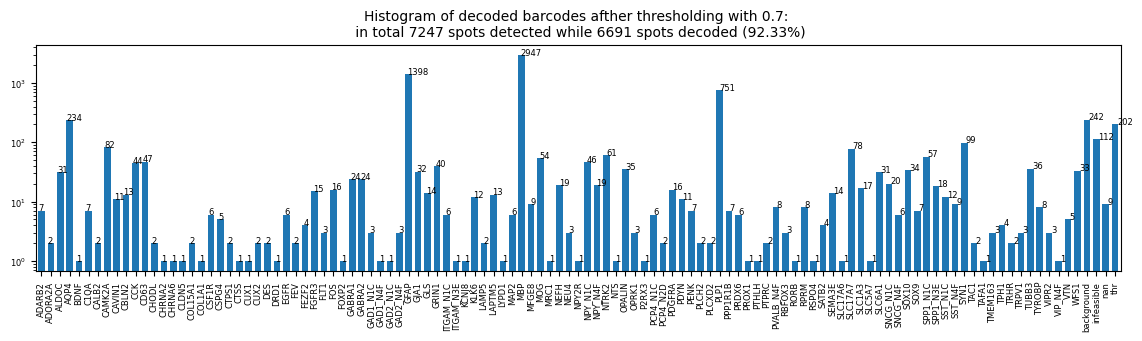

In [11]:
thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability>thr].value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)#.sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({:.02f}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes, 100*num_decoded_barcodes/decoded_df.shape[0]), fontsize=10)       
plt.show()

* Plot spatial patterns of a few selected barcodes over the whole tile 

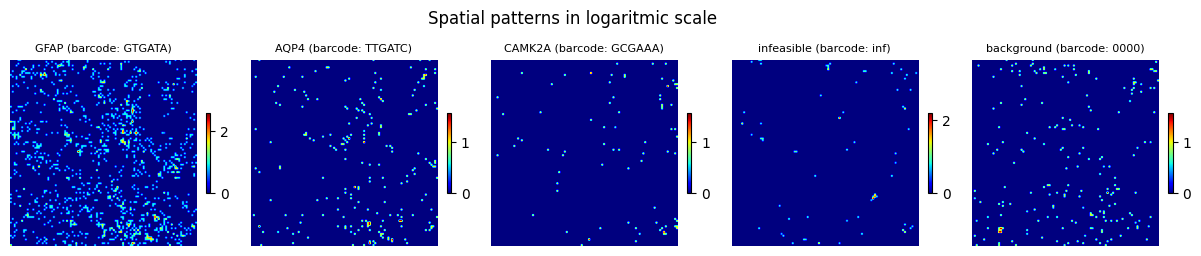

In [12]:
names = ['GFAP', 'AQP4','CAMK2A','infeasible','background']
log_scale = True
fig, ax = plt.subplots(1, len(names), figsize=(3*len(names), 3), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df, names[i], grid=20, thr=0.7, plot_probs=True)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('Spatial patterns in logaritmic scale')
plt.show()

* Plot all detected / decoded spots and a selected barcode over a zoom of the anchor channel

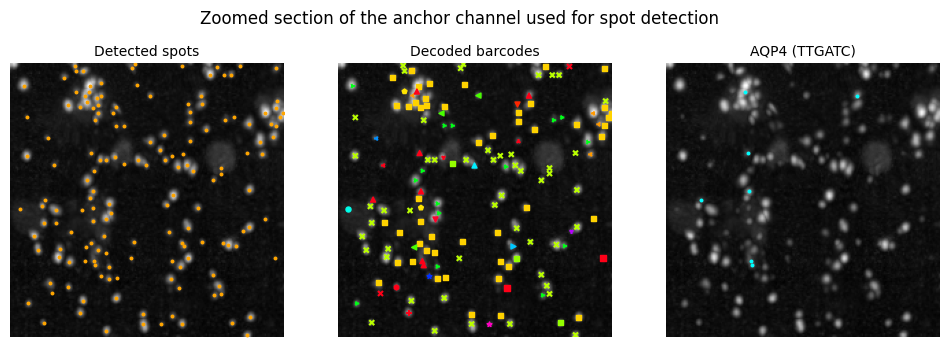

In [13]:
x00 = 1150; y00 = 750 #coordinates of the zoom (between 0--2000)
delta = 200 #size of the zoom in each axis (up to 2000)
anchor_zoom = spots_out['anchors'][0,y00:y00+delta,x00:x00+delta] #anchor of the last loaded tile
#in case multiple tiles were used, find coordinates corresponding to the last one loaded
y00 = y00+(int(decoded_df.Tile.iloc[-1][-2:].replace('Y',''))-tiles_to_load['y_start'])*tiles_info['tile_size']
x00 = x00+(int(decoded_df.Tile.iloc[-1][1:3].replace('_',''))-tiles_to_load['x_start'])*tiles_info['tile_size']

plt.figure(num=None, figsize=(12, 4), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
plt.imshow(np.log(0.06+anchor_zoom/anchor_zoom.max()),cmap='gray')
y0 = np.around(decoded_df.Y.to_numpy()).astype(np.int32)-y00; x0 = np.around(decoded_df.X.to_numpy()).astype(np.int32)-x00
y = y0[(y0>=0)&(y0<delta)&(x0>=0)&(x0<delta)];  x = x0[(y0>=0)&(y0<delta)&(x0>=0)&(x0<delta)]
plt.scatter(x,y,s=13,marker='.',c='orange') 
plt.title('Detected spots',fontsize=10)
plt.axis('off') 

from matplotlib import cm
from matplotlib.lines import Line2D
markers = list(Line2D.markers.keys()); markersL = markers[1:20]*(int(K/20)+2)
hsv_cols = cm.get_cmap('hsv', K+1); colL=hsv_cols(range(2*K)); colL=np.concatenate((colL[::2,],colL[1::2,]))
plt.subplot(1,3,2)
plt.imshow(np.log(0.06+anchor_zoom/anchor_zoom.max()),cmap='gray')
for name in gene_names:
    col = colL[np.where(gene_names==name)[0][0],:]; mar = markersL[np.where(gene_names==name)[0][0]]
    x0 = np.around(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy()).astype(np.int32)-x00
    y0 = np.around(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy()).astype(np.int32)-y00
    y = y0[(y0>=0)&(y0<delta)&(x0>=0)&(x0<delta)]; x = x0[(y0>=0)&(y0<delta)&(x0>=0)&(x0<delta)]
    plt.scatter(x,y,s=13,marker=mar,c=np.repeat(col.reshape((1,4)),x.shape[0],axis=0))             
plt.title('Decoded barcodes',fontsize=10)
plt.axis('off') 

plt.subplot(1,3,3)
plt.imshow(np.log(0.06+anchor_zoom/anchor_zoom.max()),cmap='gray')
name = 'AQP4'; thr=0.7
x0 = np.around(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy()).astype(np.int32)-x00
y0 = np.around(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy()).astype(np.int32)-y00
y = y0[(y0>=0)&(y0<delta)&(x0>=0)&(x0<delta)]; x = x0[(y0>=0)&(y0<delta)&(x0>=0)&(x0<delta)]
plt.scatter(x,y,s=13,marker='.',c='cyan') 
plt.title('{} ({})'.format(name,decoded_df.Code[decoded_df.Name==name].to_numpy()[0]),fontsize=10)
plt.axis('off') 

plt.suptitle('Zoomed section of the anchor channel used for spot detection')
plt.show()